## Arrieta for Cy Young
### 2015-09-28

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from collections import defaultdict, Counter, OrderedDict

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 4

ja = '#D12325' # cubs red ... cubs blue = '#0E3386'
zg = '#005596' # dodger blue
kc = '#005596'

### remove summary rows from game logs

In [2]:
ll -R data/

total 0
drwxr-xr-x@ 3 gjreda  staff  102 Oct 20 16:45 cyyoung/
drwxr-xr-x@ 5 gjreda  staff  170 Nov  2 11:38 gamelogs/
drwxr-xr-x@ 6 gjreda  staff  204 Oct 20 12:11 pitchfx/
drwxr-xr-x@ 5 gjreda  staff  170 Oct 20 11:31 raw/
drwxr-xr-x@ 2 gjreda  staff   68 Oct 20 11:52 teams/

data//cyyoung:
total 184
-rw-r--r--@ 1 gjreda  staff  90803 Oct 20 16:44 results.csv

data//gamelogs:
total 48
-rw-r--r--@ 1 gjreda  staff  5949 Nov  2 11:38 arrieta2015.csv
-rw-r--r--@ 1 gjreda  staff  5754 Nov  2 11:38 greinke2015.csv
-rw-r--r--@ 1 gjreda  staff  5935 Nov  2 11:38 kershaw2015.csv

data//pitchfx:
total 10376
-rw-r-----@ 1 gjreda  staff  1384144 Oct 20 11:23 arrieta.csv
-rw-r-----@ 1 gjreda  staff  1309051 Oct 20 11:23 greinke.csv
-rw-r-----@ 1 gjreda  staff  1355032 Oct 20 11:23 kershaw.csv
-rw-r-----@ 1 gjreda  staff  1261494 Oct  9 10:36 lester-20151009.csv

data//raw:
total 48
-rw-r--r--@ 1 gjreda  staff  7061 Oct 20 11:30 arrieta2015.csv
-rw-r--r--@ 1 gjreda  staff  6866 Oct 20 11:31 greink

In [3]:
!head -n 1 data/raw/arrieta2015.csv > data/gamelogs/headers.csv
!cat data/raw/arrieta2015.csv | egrep -v '^[A-Z,]' > data/gamelogs/arrieta-tmp.csv
!cat data/raw/greinke2015.csv | egrep -v '^[A-Z,]' > data/gamelogs/greinke-tmp.csv
!cat data/raw/kershaw2015.csv | egrep -v '^[A-Z,]' > data/gamelogs/kershaw-tmp.csv
!cat data/gamelogs/headers.csv data/gamelogs/arrieta-tmp.csv > data/gamelogs/arrieta2015.csv
!cat data/gamelogs/headers.csv data/gamelogs/greinke-tmp.csv > data/gamelogs/greinke2015.csv
!cat data/gamelogs/headers.csv data/gamelogs/kershaw-tmp.csv > data/gamelogs/kershaw2015.csv
!rm data/gamelogs/*tmp.csv
!rm data/gamelogs/headers.csv

## 2015 Season Analysis

#### Load game log files

In [4]:
# split on parens to handle double header games - we don't care which game they pitched
def to_date(s):
    try:
        return pd.to_datetime(s.strip().split('(')[0].strip() + ', 2015', format='%b %d, %Y')
    except:
        return pd.to_datetime(s.split('(')[0].strip() + ', 2015', format='%A %b %d, %Y')

In [5]:
# game logs
arrieta = pd.read_csv('data/gamelogs/arrieta2015.csv', parse_dates=['Date'], date_parser=to_date, index_col='Date')
greinke = pd.read_csv('data/gamelogs/greinke2015.csv', parse_dates=['Date'], date_parser=to_date, index_col='Date')
kershaw = pd.read_csv('data/gamelogs/kershaw2015.csv', parse_dates=['Date'], date_parser=to_date, index_col='Date')

seasonidx = pd.date_range('2015-04-05', '2015-10-04')
arrieta = arrieta.reindex(index=seasonidx, fill_value=0.)
greinke = greinke.reindex(index=seasonidx, fill_value=0.)
kershaw = kershaw.reindex(index=seasonidx, fill_value=0.)

In [6]:
allstarbreak = to_date('Jul 14')
print(allstarbreak)

2015-07-14 00:00:00


#### Convert innings column

Partial innings are stored as 7.1 or 7.2 in the Baseball Reference data. Convert it to properly represent 1/3 or 2/3 of an inning (necessary for various `rate` calculations).

In [7]:
def to_innings(IP):
    full, partial = map(float, str(IP).split('.'))
    return full + (partial / 3.)

arrieta['IP'] = arrieta.IP.apply(to_innings)
greinke['IP'] = greinke.IP.apply(to_innings)
kershaw['IP'] = kershaw.IP.apply(to_innings)

### and conversions. looking at you, IP.

In [8]:
arrieta['rollingIP'] = arrieta.IP.cumsum()
arrieta['IPGame'] = arrieta.rollingIP / arrieta.Rk
arrieta['rollingER'] = arrieta.ER.cumsum()
arrieta['rollingERA'] = arrieta['rollingER'] / (arrieta['rollingIP'] / 9.)
arrieta['strikeoutsPerIP'] = arrieta.SO.cumsum() / arrieta['rollingIP']
arrieta['K/9'] = arrieta.SO.cumsum() / (arrieta['rollingIP'] / 9.)
arrieta['strikeoutsPerBF'] = arrieta.SO.cumsum() / arrieta.BF.cumsum()
arrieta['hitsPerIP'] = arrieta.H.cumsum() / arrieta['rollingIP']
arrieta['hitsPerAB'] = arrieta.H.cumsum() / arrieta.AB.cumsum()
arrieta['rollingWHIP'] = (arrieta.H.cumsum() + arrieta.BB.cumsum()) / arrieta['rollingIP']
# opponents against
arrieta['1B'] = arrieta.H - (arrieta['2B'] + arrieta['3B'] + arrieta['HR'])
arrieta['AVG'] = arrieta.H.cumsum() / arrieta.AB.cumsum()
arrieta['OBP'] = (arrieta.H.cumsum() + arrieta.BB.cumsum() + arrieta.HBP.cumsum()) \
                            / (arrieta.AB.cumsum() + arrieta.BB.cumsum() + arrieta.HBP.cumsum() + arrieta.SF.cumsum())
arrieta['SLG'] = (arrieta['1B'].cumsum() + (arrieta['2B'].cumsum() * 2) + \
                         (arrieta['3B'].cumsum() * 3) + (arrieta['HR'].cumsum() * 4)) \
                            / arrieta.AB.cumsum()
arrieta['OPS'] = arrieta.OBP + arrieta.SLG

# rates
arrieta['BABIP'] = (arrieta.H.cumsum() - arrieta.HR.cumsum()) \
                        / (arrieta.AB.cumsum() - arrieta.SO.cumsum() - arrieta.HR.cumsum() + arrieta.SF.cumsum())
arrieta['HR%'] = arrieta.HR.cumsum() / arrieta.BF.cumsum()
arrieta['XBH%'] = (arrieta['2B'].cumsum() + arrieta['3B'].cumsum() + arrieta['HR'].cumsum()) / arrieta.BF.cumsum()
arrieta['K%'] = arrieta['SO'].cumsum() / arrieta.BF.cumsum()
arrieta['IP%'] = (arrieta.AB.cumsum() - arrieta.SO.cumsum() - arrieta.HR.cumsum() + arrieta.SF.cumsum()) \
                    / arrieta.BF.cumsum()
arrieta['GB%'] = arrieta['GB'].cumsum() \
                    / (arrieta.AB.cumsum() - arrieta.SO.cumsum() - arrieta.HR.cumsum() + arrieta.SF.cumsum())

## greinke
greinke['rollingIP'] = greinke.IP.cumsum()
greinke['IPGame'] = greinke.rollingIP / greinke.Rk
greinke['rollingER'] = greinke.ER.cumsum()
greinke['rollingERA'] = greinke['rollingER'] / (greinke['rollingIP'] / 9.)
greinke['strikeoutsPerIP'] = greinke.SO.cumsum() / greinke['rollingIP']
greinke['K/9'] = greinke.SO.cumsum() / (greinke['rollingIP'] / 9.)
greinke['strikeoutsPerBF'] = greinke.SO.cumsum() / greinke.BF.cumsum()
greinke['hitsPerIP'] = greinke.H.cumsum() / greinke['rollingIP']
greinke['hitsPerAB'] = greinke.H.cumsum() / greinke.AB.cumsum()
greinke['rollingWHIP'] = (greinke.H.cumsum() + greinke.BB.cumsum()) / greinke['rollingIP']
greinke['1B'] = greinke.H - (greinke['2B'] + greinke['3B'] + greinke['HR'])
greinke['AVG'] = greinke.H.cumsum() / greinke.AB.cumsum()
greinke['OBP'] = (greinke.H.cumsum() + greinke.BB.cumsum() + greinke.HBP.cumsum()) \
                            / (greinke.AB.cumsum() + greinke.BB.cumsum() + greinke.HBP.cumsum() + greinke.SF.cumsum())
greinke['SLG'] = (greinke['1B'].cumsum() + (greinke['2B'].cumsum() * 2) + \
                         (greinke['3B'].cumsum() * 3) + (greinke['HR'].cumsum() * 4)) \
                            / greinke.AB.cumsum()
greinke['OPS'] = greinke.OBP + greinke.SLG
greinke['BABIP'] = (greinke.H.cumsum() - greinke.HR.cumsum()) \
                        / (greinke.AB.cumsum() - greinke.SO.cumsum() - greinke.HR.cumsum() + greinke.SF.cumsum())
greinke['HR%'] = greinke.HR.cumsum() / greinke.BF.cumsum()
greinke['XBH%'] = (greinke['2B'].cumsum() + greinke['3B'].cumsum() + greinke['HR'].cumsum()) / greinke.BF.cumsum()
greinke['K%'] = greinke['SO'].cumsum() / greinke.BF.cumsum()
greinke['IP%'] = (greinke.AB.cumsum() - greinke.SO.cumsum() - greinke.HR.cumsum() + greinke.SF.cumsum()) \
                    / greinke.BF.cumsum()
greinke['GB%'] = greinke['GB'].cumsum() \
                    / (greinke.AB.cumsum() - greinke.SO.cumsum() - greinke.HR.cumsum() + greinke.SF.cumsum())

## kershaw
kershaw['rollingIP'] = kershaw.IP.cumsum()
kershaw['IPGame'] = kershaw.rollingIP / kershaw.Rk
kershaw['rollingER'] = kershaw.ER.cumsum()
kershaw['rollingERA'] = kershaw['rollingER'] / (kershaw['rollingIP'] / 9.)
kershaw['strikeoutsPerIP'] = kershaw.SO.cumsum() / kershaw['rollingIP']
kershaw['K/9'] = kershaw.SO.cumsum() / (kershaw['rollingIP'] / 9.)
kershaw['strikeoutsPerBF'] = kershaw.SO.cumsum() / kershaw.BF.cumsum()
kershaw['hitsPerIP'] = kershaw.H.cumsum() / kershaw['rollingIP']
kershaw['hitsPerAB'] = kershaw.H.cumsum() / kershaw.AB.cumsum()
kershaw['rollingWHIP'] = (kershaw.H.cumsum() + kershaw.BB.cumsum()) / kershaw['rollingIP']
kershaw['1B'] = kershaw.H - (kershaw['2B'] + kershaw['3B'] + kershaw['HR'])
kershaw['AVG'] = kershaw.H.cumsum() / kershaw.AB.cumsum()
kershaw['OBP'] = (kershaw.H.cumsum() + kershaw.BB.cumsum() + kershaw.HBP.cumsum()) \
                            / (kershaw.AB.cumsum() + kershaw.BB.cumsum() + kershaw.HBP.cumsum() + kershaw.SF.cumsum())
kershaw['SLG'] = (kershaw['1B'].cumsum() + (kershaw['2B'].cumsum() * 2) + \
                         (kershaw['3B'].cumsum() * 3) + (kershaw['HR'].cumsum() * 4)) \
                            / kershaw.AB.cumsum()
kershaw['OPS'] = kershaw.OBP + kershaw.SLG
kershaw['BABIP'] = (kershaw.H.cumsum() - kershaw.HR.cumsum()) \
                        / (kershaw.AB.cumsum() - kershaw.SO.cumsum() - kershaw.HR.cumsum() + kershaw.SF.cumsum())
kershaw['HR%'] = kershaw.HR.cumsum() / kershaw.BF.cumsum()
kershaw['XBH%'] = (kershaw['2B'].cumsum() + kershaw['3B'].cumsum() + kershaw['HR'].cumsum()) / kershaw.BF.cumsum()
kershaw['K%'] = kershaw['SO'].cumsum() / kershaw.BF.cumsum()
kershaw['IP%'] = (kershaw.AB.cumsum() - kershaw.SO.cumsum() - kershaw.HR.cumsum() + kershaw.SF.cumsum()) \
                    / kershaw.BF.cumsum()
kershaw['GB%'] = kershaw['GB'].cumsum() \
                    / (kershaw.AB.cumsum() - kershaw.SO.cumsum() - kershaw.HR.cumsum() + kershaw.SF.cumsum())

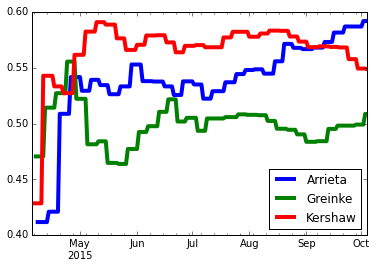

In [9]:
ax = arrieta['GB%'].plot(label='Arrieta')
greinke['GB%'].plot(ax=ax, label='Greinke')
kershaw['GB%'].plot(ax=ax, label='Kershaw')
plt.legend(loc='best')

### Arrieta's Second Half

In [10]:
arrieta2H = arrieta.ix[allstarbreak:].copy()
arrieta2H['rollingIP'] = arrieta2H.IP.cumsum()
arrieta2H['IPGame'] = arrieta2H.rollingIP / arrieta2H.Rk
arrieta2H['rollingER'] = arrieta2H.ER.cumsum()
arrieta2H['rollingERA'] = arrieta2H['rollingER'] / (arrieta2H['rollingIP'] / 9.)
arrieta2H['strikeoutsPerIP'] = arrieta2H.SO.cumsum() / arrieta2H['rollingIP']
arrieta2H['K/9'] = arrieta2H.SO.cumsum() / (arrieta2H['rollingIP'] / 9.)
arrieta2H['strikeoutsPerBF'] = arrieta2H.SO.cumsum() / arrieta2H.BF.cumsum()
arrieta2H['hitsPerIP'] = arrieta2H.H.cumsum() / arrieta2H['rollingIP']
arrieta2H['hitsPerAB'] = arrieta2H.H.cumsum() / arrieta2H.AB.cumsum()
arrieta2H['rollingWHIP'] = (arrieta2H.H.cumsum() + arrieta2H.BB.cumsum()) / arrieta2H['rollingIP']
# opponents against
arrieta2H['1B'] = arrieta2H.H - (arrieta2H['2B'] + arrieta2H['3B'] + arrieta2H['HR'])
arrieta2H['AVG'] = arrieta2H.H.cumsum() / arrieta2H.AB.cumsum()
arrieta2H['OBP'] = (arrieta2H.H.cumsum() + arrieta2H.BB.cumsum() + arrieta2H.HBP.cumsum()) \
                            / (arrieta2H.AB.cumsum() + arrieta2H.BB.cumsum() + arrieta2H.HBP.cumsum() + arrieta2H.SF.cumsum())
arrieta2H['SLG'] = (arrieta2H['1B'].cumsum() + (arrieta2H['2B'].cumsum() * 2) + \
                         (arrieta2H['3B'].cumsum() * 3) + (arrieta2H['HR'].cumsum() * 4)) \
                            / arrieta2H.AB.cumsum()
arrieta2H['OPS'] = arrieta2H.OBP + arrieta2H.SLG

# rates
arrieta2H['BABIP'] = (arrieta2H.H.cumsum() - arrieta2H.HR.cumsum()) \
                        / (arrieta2H.AB.cumsum() - arrieta2H.SO.cumsum() - arrieta2H.HR.cumsum() + arrieta2H.SF.cumsum())
arrieta2H['HR%'] = arrieta2H.HR.cumsum() / arrieta2H.BF.cumsum()
arrieta2H['XBH%'] = (arrieta2H['2B'].cumsum() + arrieta2H['3B'].cumsum() + arrieta2H['HR'].cumsum()) / arrieta2H.BF.cumsum()
arrieta2H['K%'] = arrieta2H['SO'].cumsum() / arrieta2H.BF.cumsum()
arrieta2H['IP%'] = (arrieta2H.AB.cumsum() - arrieta2H.SO.cumsum() - arrieta2H.HR.cumsum() + arrieta2H.SF.cumsum()) \
                    / arrieta2H.BF.cumsum()

### Grid O' Stats

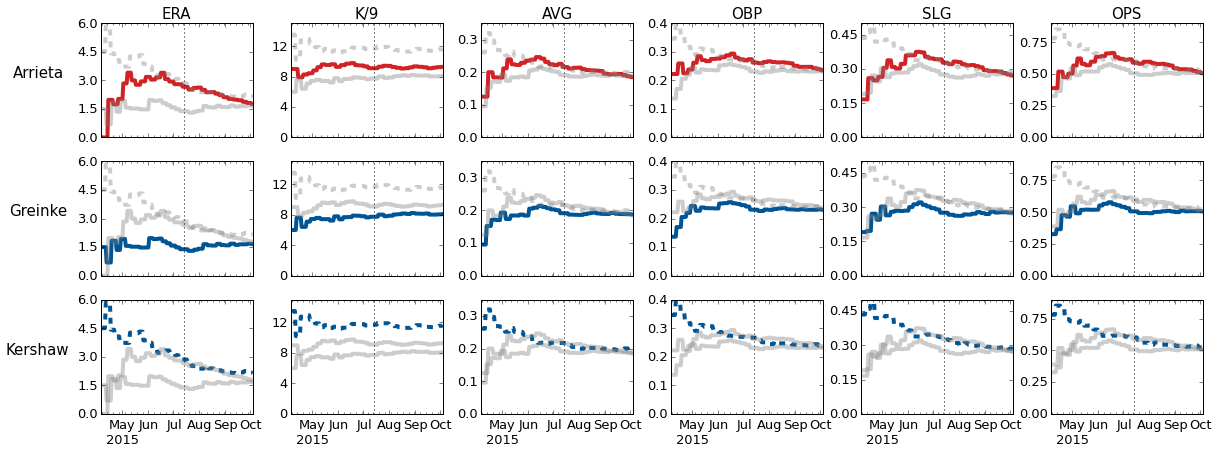

In [11]:
PITCHERS = {'Arrieta': {'df': arrieta, 'color': ja, 'style': '-'},
            'Greinke': {'df': greinke, 'color': zg, 'style': '-'},
            'Kershaw': {'df': kershaw, 'color': kc, 'style': '--'}}
PITCHERS = OrderedDict(sorted(PITCHERS.items()))
stats = ['rollingERA', 'K/9', 'AVG', 'OBP', 'SLG', 'OPS']
row_titles = ['{}'.format(row_title) for row_title in PITCHERS.keys()]
col_titles = ['{}'.format(col_title.replace('rolling', '')) for col_title in stats]

fig, axes = plt.subplots(figsize=(16,6), nrows=len(PITCHERS), ncols=len(stats), sharex=True)
fig.tight_layout(pad=1.2, h_pad=1.5)

# label each column with stat name
for ax, col_title in zip(axes[0], col_titles):
    ax.set_title(col_title, size=15)

# label each row with player name
for ax, row_title in zip(axes[:,0], row_titles):
    ax.set_ylabel(row_title, rotation=0, size=15, labelpad=40)

for i, (name, pitcher) in enumerate(PITCHERS.items()):
    for j, stat in enumerate(stats):
        title = '{}: {}'.format(name, stat.replace('rolling', '')) # remove "rolling" from "rollingERA"
        pitcher['df'][stat].plot(ax=axes[i,j], color=pitcher['color'], linestyle=pitcher['style'])

        # for ease of comparison, let's plot the other pitchers on the same chart
        # but let's make them a light grey with the appropriate linestyle
        for k, v in PITCHERS.items():
            if k != name:
                v['df'][stat].plot(ax=axes[i,j], color='grey', alpha=0.4, linestyle=v['style'])
        
        axes[i,j].tick_params(axis='both', which='major', labelsize=13)
        axes[i,j].axvline(allstarbreak, color='k', linestyle=':', linewidth=1)
        axes[i,j].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[i,0].set_ylim(0, 6) # ERA
        axes[i,1].set_ylim(0, 15.) # K/9
        axes[i,2].set_ylim(0, .350) # AVG
        axes[i,3].set_ylim(0, .4) # OBP
        axes[i,4].set_ylim(0, .5) # SLG
        axes[i,5].set_ylim(0, .9) # OPS
#         axes[i,j].spines['top'].set_visible(False)
#         axes[i,j].spines['right'].set_visible(False)
plt.savefig('images/stats-comparison.png', bbox_inches='tight', dpi=120)

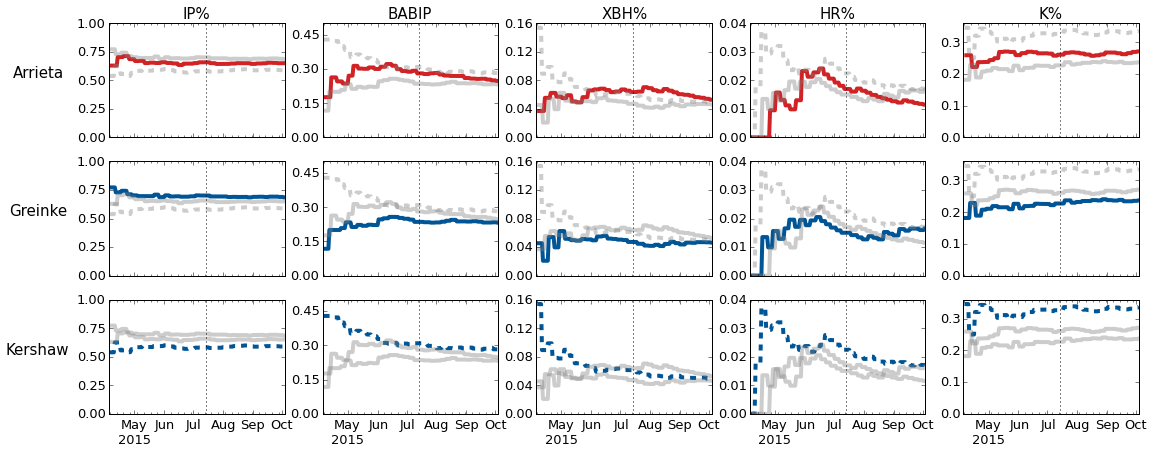

In [12]:
stats = ['IP%', 'BABIP', 'XBH%', 'HR%', 'K%']

row_titles = ['{}'.format(row_title) for row_title in PITCHERS.keys()]
col_titles = ['{}'.format(col_title) for col_title in stats]

fig, axes = plt.subplots(figsize=(15,6), nrows=len(PITCHERS), ncols=len(stats), sharex=True)
fig.tight_layout(pad=1.2, h_pad=1.5)

# label each column with stat name
for ax, col_title in zip(axes[0], col_titles):
    ax.set_title(col_title, size=15)

# label each row with player name
for ax, row_title in zip(axes[:,0], row_titles):
    ax.set_ylabel(row_title, rotation=0, size=15, labelpad=40)

for i, (name, pitcher) in enumerate(PITCHERS.items()):
    for j, stat in enumerate(stats):
        title = '{}: {}'.format(name, stat) # remove "rolling" from "rollingERA"
        pitcher['df'][stat].plot(ax=axes[i,j], color=pitcher['color'], linestyle=pitcher['style'])
        
        # for ease of comparison, let's plot the other pitchers on the same chart
        # but let's make them a light grey with the appropriate linestyle
        for k, v in PITCHERS.items():
            if k != name:
                v['df'][stat].plot(ax=axes[i,j], color='grey', alpha=0.4, linestyle=v['style'])

        axes[i,j].tick_params(axis='both', which='major', labelsize=13)
        axes[i,j].axvline(allstarbreak, color='k', linestyle=':', linewidth=1)
        axes[i,j].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[i,0].set_ylim(0, 1.) # IP%
        axes[i,1].set_ylim(0, .500) # BABIP
        axes[i,2].set_ylim(0, .16) # XBH%
        axes[i,3].set_ylim(0, .04) # HR%
        axes[i,4].set_ylim(0, .36) # K%
#         axes[i,j].spines['top'].set_visible(False)
#         axes[i,j].spines['right'].set_visible(False)
plt.savefig('images/rates-comparison.png', bbox_inches='tight', dpi=120)

## Season Simulation

### What if we replayed the season (sampling randomly from their performances)? Can we tell who is truly the ERA winner?

In [13]:
# use the bootstrap to pick a "season" with replacement.
# do this 1000 times. compare the distributions of important stats
np.random.seed(49)

arrietaSeasons = []
greinkeSeasons = []
kershawSeasons = []

for i in range(1000):
    arrietaGameIds = np.random.choice(arrieta.index, size=len(arrieta.index), replace=True)
    arrietaSeasons.append(arrieta.ix[arrietaGameIds]) # one DataFrame = one "season"
    
    greinkeGameIds = np.random.choice(greinke.index, size=len(greinke.index), replace=True)
    greinkeSeasons.append(greinke.ix[greinkeGameIds])
    
    kershawGameIds = np.random.choice(kershaw.index, size=len(kershaw.index), replace=True)
    kershawSeasons.append(kershaw.ix[kershawGameIds])


# there's a much, much better way to structure this code ... but I was thinking of more things as I was writing it
# so it just kept expanding. oh well. it's readable.

sims = {'arrieta': defaultdict(list),
        'greinke': defaultdict(list),
        'kershaw': defaultdict(list)}

for i in range(1000):
    # ERA
    sims['arrieta']['ERA'].append(arrietaSeasons[i].ER.sum() / (arrietaSeasons[i].IP.sum() / 9.))
    sims['greinke']['ERA'].append(greinkeSeasons[i].ER.sum() / (greinkeSeasons[i].IP.sum() / 9.))
    sims['kershaw']['ERA'].append(kershawSeasons[i].ER.sum() / (kershawSeasons[i].IP.sum() / 9.))
    
    # strikeouts
    sims['arrieta']['SO'].append(arrietaSeasons[i].SO.sum())
    sims['greinke']['SO'].append(greinkeSeasons[i].SO.sum())
    sims['kershaw']['SO'].append(kershawSeasons[i].SO.sum())
    
    # hits
    sims['arrieta']['H'].append(arrietaSeasons[i].H.sum())
    sims['greinke']['H'].append(greinkeSeasons[i].H.sum())
    sims['kershaw']['H'].append(kershawSeasons[i].H.sum())

    # doubles
    sims['arrieta']['2B'].append(arrietaSeasons[i]['2B'].sum())
    sims['greinke']['2B'].append(greinkeSeasons[i]['2B'].sum())
    sims['kershaw']['2B'].append(kershawSeasons[i]['2B'].sum())
    
    # doubles
    sims['arrieta']['3B'].append(arrietaSeasons[i]['3B'].sum())
    sims['greinke']['3B'].append(greinkeSeasons[i]['3B'].sum())
    sims['kershaw']['3B'].append(kershawSeasons[i]['3B'].sum())
    
    # home runs
    sims['arrieta']['HR'].append(arrietaSeasons[i].HR.sum())
    sims['greinke']['HR'].append(greinkeSeasons[i].HR.sum())
    sims['kershaw']['HR'].append(kershawSeasons[i].HR.sum())
    
    # walks
    sims['arrieta']['BB'].append(arrietaSeasons[i].BB.sum())
    sims['greinke']['BB'].append(greinkeSeasons[i].BB.sum())
    sims['kershaw']['BB'].append(kershawSeasons[i].BB.sum())
    
    # HBP
    sims['arrieta']['HBP'].append(arrietaSeasons[i].HBP.sum())
    sims['greinke']['HBP'].append(greinkeSeasons[i].HBP.sum())
    sims['kershaw']['HBP'].append(kershawSeasons[i].HBP.sum())
    
    # sacrifice flies
    sims['arrieta']['SF'].append(arrietaSeasons[i].SF.sum())
    sims['greinke']['SF'].append(greinkeSeasons[i].SF.sum())
    sims['kershaw']['SF'].append(kershawSeasons[i].SF.sum())
    
    # opponent batting average
    sims['arrieta']['AVG'].append(arrietaSeasons[i].H.sum() / arrietaSeasons[i].AB.sum())
    sims['greinke']['AVG'].append(greinkeSeasons[i].H.sum() / greinkeSeasons[i].AB.sum())
    sims['kershaw']['AVG'].append(kershawSeasons[i].H.sum() / kershawSeasons[i].AB.sum())
    
    # opponent OBP
    arrietaOBP = (arrietaSeasons[i].H.sum() + arrietaSeasons[i].BB.sum() + arrietaSeasons[i].HBP.sum()) \
                    / (arrietaSeasons[i].AB.sum() + arrietaSeasons[i].BB.sum() + \
                       arrietaSeasons[i].HBP.sum() + arrietaSeasons[i].SF.sum())
        
    greinkeOBP = (greinkeSeasons[i].H.sum() + greinkeSeasons[i].BB.sum() + greinkeSeasons[i].HBP.sum()) \
                    / (greinkeSeasons[i].AB.sum() + greinkeSeasons[i].BB.sum() + \
                       greinkeSeasons[i].HBP.sum() + greinkeSeasons[i].SF.sum())
        
    kershawOBP = (kershawSeasons[i].H.sum() + kershawSeasons[i].BB.sum() + kershawSeasons[i].HBP.sum()) \
                    / (kershawSeasons[i].AB.sum() + kershawSeasons[i].BB.sum() + \
                       kershawSeasons[i].HBP.sum() + kershawSeasons[i].SF.sum())
    sims['arrieta']['OBP'].append(arrietaOBP)
    sims['greinke']['OBP'].append(greinkeOBP)
    sims['kershaw']['OBP'].append(kershawOBP)
    
    # opponent slugging percentage
    arrietaSLG = (arrietaSeasons[i].H.sum() + \
                  (arrietaSeasons[i]['2B'].sum() * 2) + \
                  (arrietaSeasons[i]['3B'].sum() * 3) + \
                  (arrietaSeasons[i]['HR'].sum() * 4)) / arrietaSeasons[i]['AB'].sum()
        
    greinkeSLG = (greinkeSeasons[i].H.sum() + \
                  (greinkeSeasons[i]['2B'].sum() * 2) + \
                  (greinkeSeasons[i]['3B'].sum() * 3) + \
                  (greinkeSeasons[i]['HR'].sum() * 4)) / greinkeSeasons[i]['AB'].sum()
    
    kershawSLG = (kershawSeasons[i].H.sum() + \
                  (kershawSeasons[i]['2B'].sum() * 2) + \
                  (kershawSeasons[i]['3B'].sum() * 3) + \
                  (kershawSeasons[i]['HR'].sum() * 4)) / kershawSeasons[i]['AB'].sum()
    sims['arrieta']['SLG'].append(arrietaSLG)
    sims['greinke']['SLG'].append(greinkeSLG)
    sims['kershaw']['SLG'].append(kershawSLG)
    
    # at bats
    sims['arrieta']['AB'].append(arrietaSeasons[i].AB.sum())
    sims['greinke']['AB'].append(greinkeSeasons[i].AB.sum())
    sims['kershaw']['AB'].append(kershawSeasons[i].AB.sum())
    
    # batters faced
    sims['arrieta']['BF'].append(arrietaSeasons[i].BF.sum())
    sims['greinke']['BF'].append(greinkeSeasons[i].BF.sum())
    sims['kershaw']['BF'].append(kershawSeasons[i].BF.sum())

    # pitches
    sims['arrieta']['Pit'].append(arrietaSeasons[i].Pit.sum())
    sims['greinke']['Pit'].append(greinkeSeasons[i].Pit.sum())
    sims['kershaw']['Pit'].append(kershawSeasons[i].Pit.sum())
    
    # strikes
    sims['arrieta']['Str'].append(arrietaSeasons[i].Str.sum())
    sims['greinke']['Str'].append(greinkeSeasons[i].Str.sum())
    sims['kershaw']['Str'].append(kershawSeasons[i].Str.sum())
    
    # strikes - looking
    sims['arrieta']['StL'].append(arrietaSeasons[i].StL.sum())
    sims['greinke']['StL'].append(greinkeSeasons[i].StL.sum())
    sims['kershaw']['StL'].append(kershawSeasons[i].StL.sum())
    
    # strikes - swinging
    sims['arrieta']['StS'].append(arrietaSeasons[i].StS.sum())
    sims['greinke']['StS'].append(greinkeSeasons[i].StS.sum())
    sims['kershaw']['StS'].append(kershawSeasons[i].StS.sum())

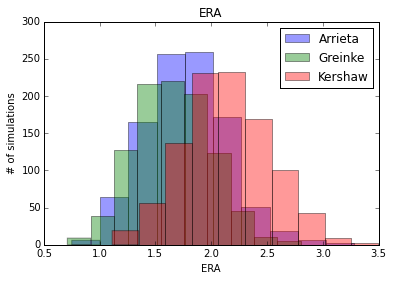

In [14]:
plt.title('ERA')
plt.hist(sims['arrieta']['ERA'], label='Arrieta', alpha=.4)
plt.hist(sims['greinke']['ERA'], label='Greinke', alpha=.4)
plt.hist(sims['kershaw']['ERA'], label='Kershaw', alpha=.4)
plt.xlabel('ERA')
plt.ylabel('# of simulations')
plt.legend(loc='best');

In [15]:
# helper functions for proper rounding of stats
round_1 = lambda x: round(x, 1)
round_2 = lambda x: round(x, 2)
round_3 = lambda x: round(x, 3)

arrietaERA = list(map(round_2, sims['arrieta']['ERA']))
greinkeERA = list(map(round_2, sims['greinke']['ERA']))
kershawERA = list(map(round_2, sims['kershaw']['ERA']))

arrieta_cdf = pd.Series(dict(Counter(arrietaERA)))
greinke_cdf = pd.Series(dict(Counter(greinkeERA)))
kershaw_cdf = pd.Series(dict(Counter(kershawERA)))

In [16]:
idx = np.arange(0, 3.51, .01)

# what percentage of the time do each combination wind up with the same ERA?
ERA = pd.concat([arrieta_cdf, greinke_cdf, kershaw_cdf], axis=1)
ERA.rename(columns={0: 'Arrieta', 1: 'Greinke', 2: 'Kershaw'}, inplace=True)
ERA = ERA.reindex(index=idx).fillna(0.)
ERA['Arrieta-Greinke'] = ERA[['Arrieta', 'Greinke']].min(axis=1)
ERA['Arrieta-Kershaw'] = ERA[['Arrieta', 'Kershaw']].min(axis=1)
ERA['Greinke-Kershaw'] = ERA[['Greinke', 'Kershaw']].min(axis=1)
ERA['Arrieta-Greinke-Kershaw'] = ERA[['Arrieta', 'Greinke', 'Kershaw']].min(axis=1)

In [17]:
ERA[['Arrieta-Greinke-Kershaw']].sum()

Arrieta-Greinke-Kershaw    385
dtype: float64

/Users/gjreda/.virtualenvs/pitchfx/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


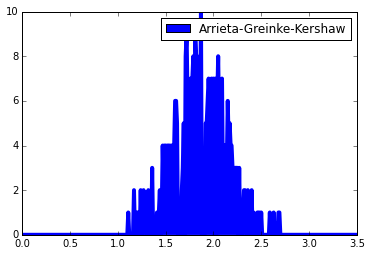

In [18]:
ERA[['Arrieta-Greinke-Kershaw']].plot(kind='area')

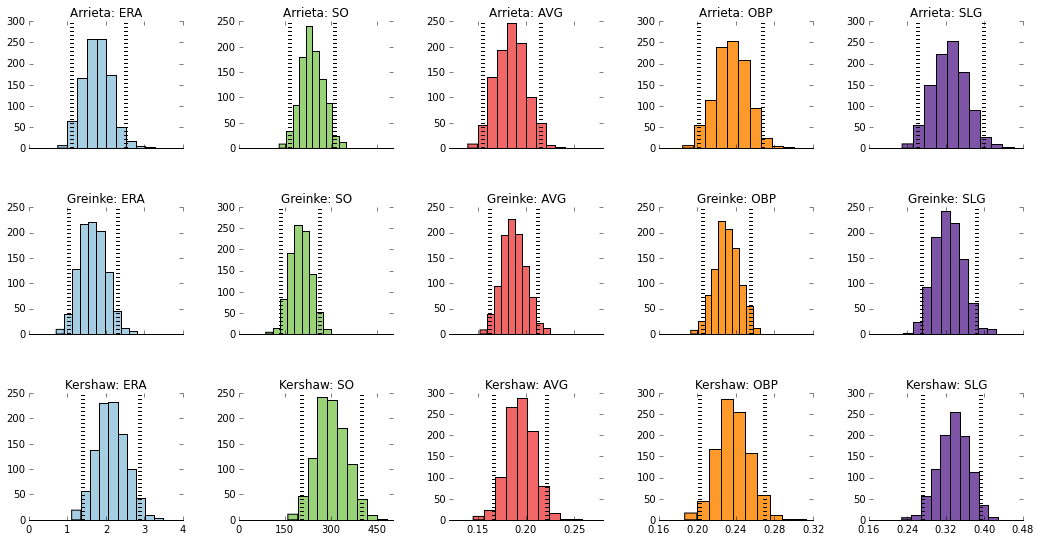

In [19]:
metrics = ['ERA', 'SO', 'AVG', 'OBP', 'SLG']
fig, axes = plt.subplots(figsize=(15,8), ncols=len(metrics), nrows=3, sharex='col', squeeze=False)
fig.tight_layout(pad=3.0, h_pad=5.0)
cmap = plt.get_cmap('Paired')

for j, metric in enumerate(metrics):
    for i, name in enumerate(sorted(sims.keys())):
        ci = np.percentile(sims[name][metric], q=[2.5, 97.5])
        axes[i,j].hist(sims[name][metric], color=cmap(1.*j/len(metrics)))
        axes[i,j].axvline(ci[0], linestyle=':', color='k')
        axes[i,j].axvline(ci[1], linestyle=':', color='k')
        axes[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[i,j].set_title('{}: {}'.format(name.capitalize(), metric))
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['left'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)

# Pitch f/x

In [20]:
arrietaPitches = pd.read_csv('data/pitchfx/arrieta.csv', parse_dates=['game_date'])
greinkePitches = pd.read_csv('data/pitchfx/greinke.csv', parse_dates=['game_date'])
kershawPitches = pd.read_csv('data/pitchfx/kershaw.csv', parse_dates=['game_date'])

## Add some columns to make things easier

In [21]:
arrietaPitches.pitch_result.value_counts()

Ball                         1148
Foul                          612
Called Strike                 605
In play, out(s)               413
Swinging Strike               352
In play, no out               128
Ball In Dirt                   42
In play, run(s)                39
Swinging Strike (Blocked)      31
Foul Tip                       25
Foul Bunt                      15
Foul (Runner Going)             9
Intent Ball                     8
Hit By Pitch                    6
Missed Bunt                     5
Name: pitch_result, dtype: int64

In [22]:
arrietaPitches.atbat_result.value_counts()

Strikeout              1165
Groundout               710
Single                  387
Walk                    270
Flyout                  245
Lineout                 197
Double                  106
Pop Out                  85
Forceout                 66
Grounded Into DP         52
Field Error              29
Home Run                 23
Fielders Choice Out      16
Hit By Pitch             15
Sac Bunt                 13
Triple                   12
Double Play              12
Intent Walk               8
Strikeout - DP            7
Runner Out                6
Bunt Groundout            6
Fielders Choice           5
Sac Fly                   2
Bunt Pop Out              1
Name: atbat_result, dtype: int64

In [23]:
# if it's not a ball, it's a strike
ball_vals = ['Ball', 'Ball In Dirt', 'Intent Ball', 'Hit By Pitch']
swing_and_miss = ['Swinging Strike', 'Swinging Strike (Blocked)', 'Missed Bunt']
hit_vals = ['Single', 'Double', 'Triple', 'Home Run']

arrietaPitches.loc[arrietaPitches.pitch_result.isin(ball_vals), 'is_strike'] = 0
arrietaPitches.loc[arrietaPitches.is_strike != 0, 'is_strike'] = 1
arrietaPitches.loc[arrietaPitches.pitch_result.isin(swing_and_miss), 'swing_and_miss'] = 1
arrietaPitches.loc[arrietaPitches.atbat_result.isin(hit_vals), 'is_hit'] = 1
arrietaPitches.loc[arrietaPitches.atbat_result == 'Single', 'total_bases'] = 1
arrietaPitches.loc[arrietaPitches.atbat_result == 'Double', 'total_bases'] = 2
arrietaPitches.loc[arrietaPitches.atbat_result == 'Triple', 'total_bases'] = 3
arrietaPitches.loc[arrietaPitches.atbat_result == 'Home Run', 'total_bases'] = 4

greinkePitches.loc[greinkePitches.pitch_result.isin(ball_vals), 'is_strike'] = 0
greinkePitches.loc[greinkePitches.is_strike != 0, 'is_strike'] = 1

kershawPitches.loc[kershawPitches.pitch_result.isin(ball_vals), 'is_strike'] = 0
kershawPitches.loc[kershawPitches.is_strike != 0, 'is_strike'] = 1

### Who gets hit harder - Arrieta vs. Greinke vs. Kershaw

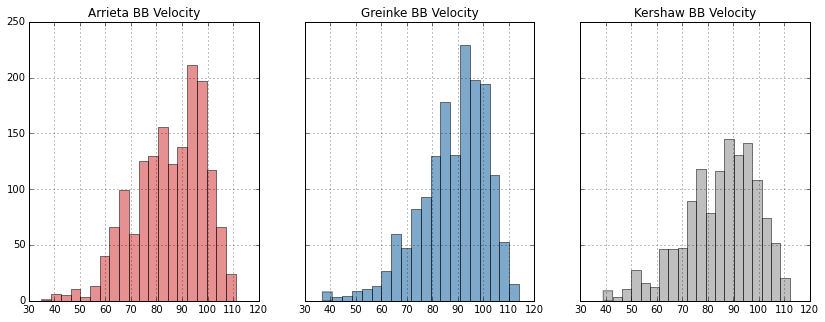

In [24]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(14,5))

arrietaPitches.batted_ball_velocity.hist(ax=axes[0], bins=20, label='Arrieta', alpha=.5, color=ja)
axes[0].set_title('Arrieta BB Velocity')
greinkePitches.batted_ball_velocity.hist(ax=axes[1], bins=20, label='Greinke', alpha=.5, color=zg)
axes[1].set_title('Greinke BB Velocity')
kershawPitches.batted_ball_velocity.hist(ax=axes[2], bins=20, label='Kershaw', alpha=.5, color='grey')
axes[2].set_title('Kershaw BB Velocity');

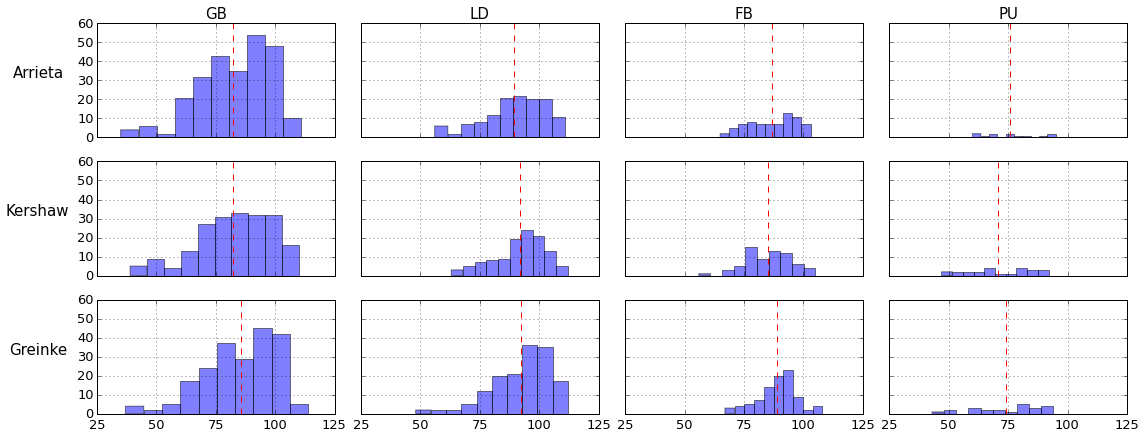

In [25]:
bbtypes = ['GB', 'LD', 'FB', 'PU']
pitchers = {'Arrieta': arrietaPitches, 'Greinke': greinkePitches, 'Kershaw': kershawPitches}

row_titles = ['{}'.format(row_title) for row_title in pitchers.keys()]
col_titles = ['{}'.format(col_title) for col_title in bbtypes]

fig, axes = plt.subplots(figsize=(15,6), nrows=len(pitchers), ncols=len(bbtypes), sharex=True, sharey=True)
fig.tight_layout(pad=1.2, h_pad=1.5)

# label each column with stat name
for ax, col_title in zip(axes[0], col_titles):
    ax.set_title(col_title, size=15)

# label each row with player name
for ax, row_title in zip(axes[:,0], row_titles):
    ax.set_ylabel(row_title, rotation=0, size=15, labelpad=40)

for i, (name, df) in enumerate(pitchers.items()):
    for j, bb in enumerate(bbtypes):
        title = '{}: {}'.format(name, bb)
        vals = df[df.batted_ball_type == bb]['batted_ball_velocity']
        vals.hist(ax=axes[i,j], alpha=.5)
        axes[i,j].axvline(np.mean(vals), color='r', linestyle='--', linewidth=1)
        axes[i,j].tick_params(axis='both', which='major', labelsize=13)
        axes[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4))
#         axes[i,j].spines['top'].set_visible(False)
#         axes[i,j].spines['left'].set_visible(False)
#         axes[i,j].spines['right'].set_visible(False)

### Is it significant?

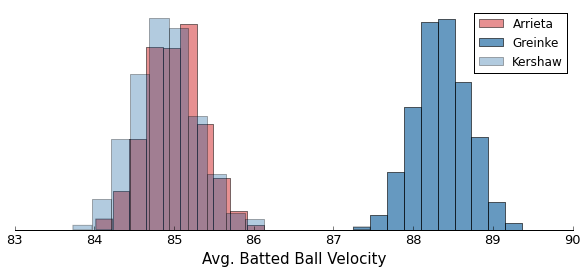

In [26]:
np.random.seed(49)

arrietaBBs = arrietaPitches[arrietaPitches.batted_ball_velocity > 0].batted_ball_velocity
greinkeBBs = greinkePitches[greinkePitches.batted_ball_velocity > 0].batted_ball_velocity
kershawBBs = kershawPitches[kershawPitches.batted_ball_velocity > 0].batted_ball_velocity
arrietaSamples = []
greinkeSamples = []
kershawSamples = []

for i in range(1000):
    arrietaSamples.append(np.random.choice(arrietaBBs, size=len(arrietaBBs), replace=True))
    greinkeSamples.append(np.random.choice(greinkeBBs, size=len(greinkeBBs), replace=True))
    kershawSamples.append(np.random.choice(kershawBBs, size=len(kershawBBs), replace=True))

arrietaMeans = [np.mean(obs) for obs in arrietaSamples]
greinkeMeans = [np.mean(obs) for obs in greinkeSamples]
kershawMeans = [np.mean(obs) for obs in kershawSamples]

fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(arrietaMeans, alpha=.5, label='Arrieta', color=ja)
plt.hist(greinkeMeans, alpha=.6, label='Greinke', color=zg)
plt.hist(kershawMeans, alpha=.3, label='Kershaw', color=kc)
plt.legend(loc='best')
plt.xlabel('Avg. Batted Ball Velocity', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(axis='both', which='major', labelsize=13)
ax.get_yaxis().set_ticks([])
plt.savefig('images/avg-batted-ball-velocity.png', bbox_inches='tight', dpi=120);

In [27]:
np.mean(greinkeMeans) - np.mean(arrietaMeans)

3.351081092880861

Statistically, we can say that Greinke gets hit harder than both Arrieta and Kershaw, though we cannot say there's a difference between Arrieta and Kershaw.

In [28]:
greinkePitches.head(3)

,name,player_id,pitch_type,pitch_result,atbat_result,start_speed,z0,x0,pfx_x,pfx_z,px,pz,break_angle,break_length,spin_rate,spin_dir,zone,balls,strikes,outs,play,game_date,inning,inning_topbot,tfs,tfs_zulu,catcher,umpire,umpire_name,stolen_base_attempt,stolen_base_success,batted_ball_type,Unnamed: 32,angle,batted_ball_velocity,direction,hc_x,hc_y,pitch_id,distance_feet,is_strike
0,Zack Greinke,425844,SL,Foul,Strikeout,86.5,6.153,-1.213,1.817,1.742,-0.053,1.887,-6.4,7.5,478.065,134.526,8,0,0,1,Jedd Gyorko strikes out swinging.,2015-10-03,6,top,22632,2015-10-04T02:26:32Z,518735,483561,Lance Barrett,0,0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,274,NaN,1
1,Zack Greinke,425844,FF,Foul,Flyout,93.6,5.954,-1.211,-2.803,9.477,-0.607,2.406,17.5,3.4,2012.489,196.412,4,0,0,2,Yangervis Solarte flies out to center fielder ...,2015-10-03,1,top,11404,2015-10-04T01:14:04Z,518735,483561,Lance Barrett,0,0,NaN,NaN,NaN,NaN,NaN,137.49,73.57,18,NaN,1
2,Zack Greinke,425844,FF,Foul,Strikeout,92.4,6.115,-0.661,-1.426,9.408,0.891,2.485,6.5,3.4,1918.983,188.580,14,0,0,0,Melvin Upton Jr. strikes out swinging.,2015-10-03,4,top,14938,2015-10-04T01:49:38Z,518735,483561,Lance Barrett,0,0,NaN,NaN,NaN,NaN,NaN,0.00,0.00,140,NaN,1


### What is the relationship between batted ball velocity and batting average against these three?

In [29]:
arrietaHit = arrietaPitches[arrietaPitches.batted_ball_velocity.notnull()]
greinkeHit = greinkePitches[greinkePitches.batted_ball_velocity.notnull()]
kershawHit = kershawPitches[kershawPitches.batted_ball_velocity.notnull()]
print('# of pitches batted')
print('====================')
print('Arrieta: %s' % len(arrietaHit))
print('Greinke: %s' % len(greinkeHit))
print('Kershaw: %s' % len(kershawHit))

# of pitches batted
Arrieta: 1591
Greinke: 1598
Kershaw: 1291


## How difficult is each of their particular pitches to hit?

In [30]:
print('Arrieta\n', arrietaPitches.pitch_type.value_counts())
print('Greinke\n', greinkePitches.pitch_type.value_counts())
print('Kershaw\n', kershawPitches.pitch_type.value_counts())

Arrieta
 SI    1225
SL     989
CU     531
FF     524
CH     145
FA      13
IN       6
Name: pitch_type, dtype: int64
Greinke
 FF    1398
SL     621
CH     599
FT     321
CU     293
EP       2
IN       2
Name: pitch_type, dtype: int64
Kershaw
 FF    1823
SL     924
CU     616
CH      18
FA       2
IN       1
Name: pitch_type, dtype: int64


## Historical Cy Young Results

In [31]:
def era_ranker(df):
    df.sort_values('earned_run_avg', inplace=True)
    df['ERA_rank'] = np.arange(len(df)) + 1
    return df

def wins_ranker(df):
    df.sort_values('W', ascending=False, inplace=True)
    df['wins_rank'] = np.arange(len(df)) + 1
    return df

In [32]:
cy = pd.read_csv('data/cyyoung/results.csv')
cy['share'] = cy.share.str.replace('%', '').apply(int) / 100
winners = cy[cy['rank'] == 1]

In [33]:
cy = cy.groupby(['year', 'league']).apply(era_ranker).sort_values(['year', 'league'], ascending=False)
cy = cy.groupby(['year', 'league']).apply(wins_ranker).sort_values(['year', 'league'], ascending=False)

In [34]:
ranks = cy[['rank', 'player', 'W', 'earned_run_avg', 'earned_run_avg_plus', 'SV', 'wins_rank', 'ERA_rank']].reset_index()

In [35]:
ranks.drop(['level_2', 'level_3', 'level_4'], axis=1, inplace=True)
ranks.set_index(['year', 'league', 'player'], inplace=True)

In [36]:
ranks.loc[ranks['rank'] == 1, 'winner'] = 1
ranks.loc[ranks['rank'] != 1, 'winner'] = 0

/Users/gjreda/.virtualenvs/pitchfx/lib/python3.5/site-packages/ipykernel/kernelbase.py:212: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


In [37]:
ranks.reset_index(inplace=True)

In [38]:
g = ranks.groupby(['year', 'league', 'wins_rank', 'ERA_rank'])['winner'].sum().unstack([1, 0]).fillna(0)
rankings = g.sum(axis=1).unstack(1).fillna(0)

/Users/gjreda/.virtualenvs/pitchfx/lib/python3.5/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [39]:
g.sum(axis=1).unstack(1).fillna(0).sum(axis=1)

/Users/gjreda/.virtualenvs/pitchfx/lib/python3.5/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


wins_rank
1     67
2     14
3      9
4      7
5      2
6      1
7      2
8      5
9      1
10     0
11     0
12     0
13     0
dtype: float64

In [40]:
rankings

ERA_rank,1,2,3,4,5,6,7,8,9,10,11,12,13
wins_rank,,,,,,,,,,,,,
1,14,14,10,10,11,3,3,2,0,0,0,0,0
2,5,2,1,3,2,1,0,0,0,0,0,0,0
3,2,3,3,0,0,1,0,0,0,0,0,0,0
4,3,2,1,1,0,0,0,0,0,0,0,0,0
5,1,0,1,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0
7,2,0,0,0,0,0,0,0,0,0,0,0,0
8,1,2,1,1,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0


### Closest Cy Young Races

In [41]:
cy.columns

Index(['league', 'H', 'R', 'points_won', 'votes_first', 'BB', 'SO', 'IBB',
       'year', 'HBP', 'whip', 'WP', 'WAR_pitch', 'GS', 'earned_run_avg_plus',
       'SHO', 'batters_faced', 'L', 'BK', 'player', 'earned_run_avg', 'IP',
       'win_loss_perc', 'SV', 'CG', 'W', 'G', 'ER', 'team_ID', 'rank', 'HR',
       'share', 'GF', 'ERA_rank', 'wins_rank'],
      dtype='object')

In [42]:
diff = cy.groupby(['year', 'rank', 'league'])['share'].sum().unstack([2,1]).fillna(0)
(diff['AL'][1] - diff['AL'][2]).order()

/Users/gjreda/.virtualenvs/pitchfx/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


year
1956    0.00
1957    0.00
1958    0.00
1959    0.00
1960    0.00
1961    0.00
1962    0.00
1963    0.00
1964    0.00
1965    0.00
1966    0.00
2012    0.02
2014    0.04
1972    0.05
1996    0.05
1980    0.06
1977    0.06
1970    0.07
1994    0.08
1971    0.11
1984    0.12
2002    0.12
1974    0.13
1975    0.20
1982    0.20
1973    0.21
1990    0.21
2007    0.24
1983    0.25
1985    0.28
2010    0.28
1981    0.30
2005    0.35
1993    0.35
2009    0.39
1992    0.40
1997    0.41
2004    0.41
1989    0.42
2008    0.43
1987    0.43
2001    0.44
1991    0.45
1978    0.46
1976    0.48
2011    0.51
2003    0.52
2013    0.53
1998    0.54
1995    0.58
1999    0.61
2000    0.61
1979    0.61
1988    0.62
2006    0.64
1986    0.70
1967    0.80
1969    0.84
1968    1.00
dtype: float64